# **`Integrative Analysis of Breast Cancer Survival, Infection Risk, and Treatment Using Optimized Machine Learning and Deep Learning Approaches`**

In [1]:
!pip install GEOparse

In [2]:
# Standard Libraries
import os
import gzip
import shutil
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import GEOparse

# Scikit-learn for Machine Learning (ML)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score, roc_curve, auc

# TensorFlow for Deep Learning (DL)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# SHAP for Model Explainability
import shap

# For saving models
import joblib

# Ignore warnings
warnings.filterwarnings('ignore')


**Retrieve GSE25066 (Breast Cancer Survival Data)**

In [3]:
# Fetch GSE25066 dataset
gse25066 = GEOparse.get_GEO("GSE25066", destdir="./")  # Downloads and parses the dataset
# View the summary of the data
print(gse25066)

08-May-2025 01:26:34 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
08-May-2025 01:26:34 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/soft/GSE25066_family.soft.gz to ./GSE25066_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/soft/GSE25066_family.soft.gz to ./GSE25066_family.soft.gz
100%|██████████| 101M/101M [00:03<00:00, 32.0MB/s] 
08-May-2025 01:26:38 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
08-May-2025 01:26:38 DEBUG downloader - Moving /tmp/tmp63uggsmk to /content/GSE25066_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp63uggsmk to /content/GSE25066_family.soft.gz
08-May-2025 01:26:39 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/soft/GSE25066_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE250

<SERIES: GSE25066 - 508 SAMPLES, 1 d(s)>


**Retrieve GSE19783 (Infection Data)**

In [4]:
# Fetch GSE19783 dataset
gse19783 = GEOparse.get_GEO("GSE19783", destdir="./")  # Downloads and parses the dataset

# View the summary of the data
print(gse19783)


08-May-2025 01:27:14 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
08-May-2025 01:27:14 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19783/soft/GSE19783_family.soft.gz to ./GSE19783_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19783/soft/GSE19783_family.soft.gz to ./GSE19783_family.soft.gz
100%|██████████| 51.3M/51.3M [00:02<00:00, 24.0MB/s]
08-May-2025 01:27:17 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
08-May-2025 01:27:17 DEBUG downloader - Moving /tmp/tmplsm5wtu8 to /content/GSE19783_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmplsm5wtu8 to /content/GSE19783_family.soft.gz
08-May-2025 01:27:17 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19783/soft/GSE19783_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19

<SERIES: GSE19783 - 216 SAMPLES, 2 d(s)>


**Survival Dataset Preprocesssing and Cleaning**

In [5]:

# Define the URL and file paths
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25066/matrix/GSE25066_series_matrix.txt.gz"
gz_file = "GSE25066_series_matrix.txt.gz"
txt_file = "GSE25066_series_matrix.txt"
csv_file = "survival_df.csv"  # Output file named as requested

# Download the .gz file
print("Downloading GSE25066_series_matrix.txt.gz...")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(gz_file, 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print(f"Failed to download. Status code: {response.status_code}")
    exit()

# Step 3: Decompress the .gz file to .txt
print("Decompressing the file...")
with gzip.open(gz_file, 'rb') as f_in:
    with open(txt_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Decompression complete!")

# Convert the tab-delimited .txt file to .csv and load as survival_df
print("Converting to CSV and loading as survival_df...")
# Read the series matrix file (skip metadata until the data table starts)
with open(txt_file, 'r') as f:
    lines = f.readlines()
    start_idx = lines.index('!series_matrix_table_begin\n') + 1  # Skip the header line
    data_lines = lines[start_idx:-1]  # Exclude the "!series_matrix_table_end" line

# Write the data portion to a temporary file for pandas to read
temp_data_file = "temp_data.txt"
with open(temp_data_file, 'w') as f:
    f.writelines(data_lines)

# Load into pandas as survival_df
survival_df = pd.read_csv(temp_data_file, sep='\t')

# Save to CSV
survival_df.to_csv(csv_file, index=False)
print(f"Conversion complete! File saved as {csv_file}")



Download complete!
Decompressing the file...
Decompression complete!
Converting to CSV and loading as survival_df...
Conversion complete! File saved as survival_df.csv


In [6]:
#  Display head and info
print("\nFirst 5 rows of survival_df:")
print(survival_df.head())



First 5 rows of survival_df:
      ID_REF  GSM615096  GSM615097  GSM615098  GSM615099  GSM615100  \
0  1007_s_at  12.359267  12.613243  11.551397  11.828700  11.983987   
1    1053_at   8.021741   7.842947   8.776267   9.523877   6.836237   
2     117_at   8.294244   5.474758   8.197121   7.907263   8.625010   
3     121_at  10.840949  11.715159  10.715077  10.750475  10.827725   
4  1255_g_at   7.874062   7.347955   6.523880   6.478643   7.336754   

   GSM615101  GSM615102  GSM615103  GSM615104  ...  GSM615819  GSM615820  \
0  11.968264  12.941168  12.564150  12.346389  ...  12.261427  11.656442   
1   8.665255   8.413069   8.292229   8.204654  ...   7.377414   8.747719   
2   7.480015   8.780554   9.817384   8.328537  ...   6.786310   8.811778   
3  10.767155  10.945211  10.905835  11.074558  ...  11.768925  11.114494   
4   6.641128   7.988518   6.809615   6.271495  ...   7.123328   6.830391   

   GSM615821  GSM615822  GSM615823  GSM615824  GSM615825  GSM615826  \
0  12.381211  1

In [7]:
print("\nSummary of survival_df:")
print(survival_df.info())


Summary of survival_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22283 entries, 0 to 22282
Columns: 509 entries, ID_REF to GSM615828
dtypes: float64(508), object(1)
memory usage: 86.5+ MB
None


In [8]:
# Clean up intermediate files
os.remove(gz_file)
os.remove(txt_file)
os.remove(temp_data_file)
print("\nCleaned up intermediate files.")


Cleaned up intermediate files.


**Infection Dataset Preprocesssing and Cleaning**

In [9]:
# Define the URL and file paths
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19783/matrix/GSE19783-GPL6480_series_matrix.txt.gz"
gz_file = "GSE19783-GPL6480_series_matrix.txt.gz"
txt_file = "GSE19783-GPL6480_series_matrix.txt"
csv_file = "infection_df.csv"  # Output file named as requested
# Download the .gz file
print("Downloading GSE19783-GPL6480_series_matrix.txt.gz...")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(gz_file, 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print(f"Failed to download. Status code: {response.status_code}")
    exit()

# Decompress the .gz file to .txt
print("Decompressing the file...")
with gzip.open(gz_file, 'rb') as f_in:
    with open(txt_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Decompression complete!")

# Convert the tab-delimited .txt file to .csv and load as infection_df
print("Converting to CSV and loading as infection_df...")
# Read the series matrix file (skip metadata until the data table starts)
with open(txt_file, 'r') as f:
    lines = f.readlines()
    start_idx = lines.index('!series_matrix_table_begin\n') + 1  # Skip the header line
    data_lines = lines[start_idx:-1]  # Exclude the "!series_matrix_table_end" line

# Write the data portion to a temporary file for pandas to read
temp_data_file = "temp_data.txt"
with open(temp_data_file, 'w') as f:
    f.writelines(data_lines)

# Load into pandas as infection_df
infection_df = pd.read_csv(temp_data_file, sep='\t')

# Save to CSV
infection_df.to_csv(csv_file, index=False)
print(f"Conversion complete! File saved as {csv_file}")

Download complete!
Decompressing the file...
Decompression complete!
Converting to CSV and loading as infection_df...
Conversion complete! File saved as infection_df.csv


In [10]:
#Display head and info
print("\nFirst 5 rows of infection_df:")
infection_df.head()


First 5 rows of infection_df:


,ID_REF,GSM496794,GSM496795,GSM496796,GSM496797,GSM496798,GSM496799,GSM496800,GSM496801,GSM496802,...,GSM496899,GSM496900,GSM496901,GSM496902,GSM496903,GSM496904,GSM496905,GSM496906,GSM496907,GSM496908
0,A_23_P100001,12.248267,12.201178,11.895794,12.902076,11.589063,10.331456,11.079664,11.864886,12.421908,...,11.629209,13.378254,10.913271,11.616635,11.156334,11.925049,9.155703,11.480566,10.901079,14.976537
1,A_23_P100011,6.675710,6.894267,7.118969,7.953695,6.768668,6.848734,6.388073,6.990956,7.579134,...,6.969739,6.944984,6.638803,6.594356,6.886821,6.749354,6.841444,7.350089,6.941325,7.373722
2,A_23_P100022,9.737563,7.826692,7.397434,7.842475,8.275041,10.541509,9.301131,8.094899,7.544444,...,7.751586,8.617615,9.207065,9.126947,9.425826,8.905016,8.190733,7.194767,11.059169,8.223181
3,A_23_P100056,7.198171,6.523736,6.655207,6.997778,6.509795,6.523532,6.428857,6.718568,6.721313,...,6.683305,6.540608,7.013080,6.552274,6.578840,6.309394,6.370467,6.633226,6.409260,6.225102
4,A_23_P100074,11.152044,10.187456,10.804726,9.877433,11.306444,11.087124,10.691868,11.082777,11.375449,...,10.212879,10.480732,10.819427,9.873439,10.711073,11.406293,10.581629,9.495987,10.865639,10.586921


In [11]:
print("\nSummary of infection_df:")
print(infection_df.info())


Summary of infection_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40996 entries, 0 to 40995
Columns: 116 entries, ID_REF to GSM496908
dtypes: float64(115), object(1)
memory usage: 36.3+ MB
None


In [12]:
# Step 6: Clean up intermediate files
os.remove(gz_file)
os.remove(txt_file)
os.remove(temp_data_file)
print("\nCleaned up intermediate files.")


Cleaned up intermediate files.


In [13]:
#  View Columns of Both CSV Files
print("Columns in survival_df:")
print(list(survival_df.columns))

print("\nColumns in infection_df:")
print(list(infection_df.columns))

Columns in survival_df:
['ID_REF', 'GSM615096', 'GSM615097', 'GSM615098', 'GSM615099', 'GSM615100', 'GSM615101', 'GSM615102', 'GSM615103', 'GSM615104', 'GSM615105', 'GSM615106', 'GSM615107', 'GSM615108', 'GSM615109', 'GSM615110', 'GSM615111', 'GSM615112', 'GSM615113', 'GSM615114', 'GSM615115', 'GSM615116', 'GSM615117', 'GSM615118', 'GSM615119', 'GSM615120', 'GSM615121', 'GSM615122', 'GSM615123', 'GSM615124', 'GSM615125', 'GSM615126', 'GSM615127', 'GSM615128', 'GSM615129', 'GSM615130', 'GSM615131', 'GSM615132', 'GSM615133', 'GSM615134', 'GSM615135', 'GSM615136', 'GSM615137', 'GSM615138', 'GSM615139', 'GSM615140', 'GSM615141', 'GSM615142', 'GSM615143', 'GSM615144', 'GSM615145', 'GSM615146', 'GSM615147', 'GSM615148', 'GSM615149', 'GSM615150', 'GSM615151', 'GSM615152', 'GSM615153', 'GSM615154', 'GSM615155', 'GSM615156', 'GSM615157', 'GSM615158', 'GSM615159', 'GSM615160', 'GSM615161', 'GSM615162', 'GSM615163', 'GSM615164', 'GSM615165', 'GSM615166', 'GSM615167', 'GSM615168', 'GSM615169', 'GS

**Preprocessing and Enhanced EDA**

In [14]:
# Preprocessing

print("Performing preprocessing forinfection and survival ...")

# Select GSM columns and include 'ID_REF' for both datasets
survival_gsm_cols = survival_df.columns[1:]  # All GSM columns for survival
infection_gsm_cols = infection_df.columns[1:]  # All GSM columns for infection

# Create a proxy grouping based on the first part of 'ID_REF' (e.g., "A_23_" for miRNA IDs)
# Rename 'ID_Type' to 'Probe_Category' for clarity
survival_df['Probe_Category'] = survival_df['ID_REF'].str.extract(r'([^_]+_[^_]+)')[0]
infection_df['Probe_Category'] = infection_df['ID_REF'].str.extract(r'([^_]+_[^_]+)')[0]


Performing preprocessing forinfection and survival ...


In [15]:
# Select GSM columns (assuming they start with 'GSM')
survival_gsm_cols = [col for col in survival_df.columns if col.startswith('GSM')]
infection_gsm_cols = [col for col in infection_df.columns if col.startswith('GSM')]


# Derive proxy outcomes using clustering on expression data
def derive_outcome(df, n_clusters=2):
    # Dynamically exclude non-numeric columns instead of hardcoding 'Gene_Probe_ID'
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if not numeric_cols.any():
        raise ValueError("No numeric columns found for clustering.")
    features = df[numeric_cols].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    return pd.Series(clusters, index=df.index, name='Outcome')

# Derive outcomes
try:
    survival_df['Survival_Outcome'] = derive_outcome(survival_df)  # 0 or 1 as proxy for survival
    survival_df['Treatment_Outcome'] = derive_outcome(survival_df)  # 0 or 1 as proxy for treatment response
    infection_df['Infection_Outcome'] = derive_outcome(infection_df)  # 0 or 1 as proxy for infection risk
except ValueError as e:
    print(f"Error deriving outcomes: {e}")
    raise

# Features
X_survival = survival_df.select_dtypes(include=[np.number]).drop(columns=['Survival_Outcome', 'Treatment_Outcome'], errors='ignore')
X_infection = infection_df.select_dtypes(include=[np.number]).drop(columns=['Infection_Outcome'], errors='ignore')

# Outcomes
y_survival = survival_df['Survival_Outcome']
y_treatment = survival_df['Treatment_Outcome']
y_infection = infection_df['Infection_Outcome']

# Normalize features
scaler = StandardScaler()
X_survival_scaled = scaler.fit_transform(X_survival)
X_infection_scaled = scaler.fit_transform(X_infection)

# Train-test split
X_sur_train, X_sur_test, y_sur_train, y_sur_test = train_test_split(X_survival_scaled, y_survival, test_size=0.2, random_state=42)
X_trt_train, X_trt_test, y_trt_train, y_trt_test = train_test_split(X_survival_scaled, y_treatment, test_size=0.2, random_state=42)
X_inf_train, X_inf_test, y_inf_train, y_inf_test = train_test_split(X_infection_scaled, y_infection, test_size=0.2, random_state=42)

# Save the scaler for later use in Gradio
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

**Explanatory Data Analysis (EDA)**

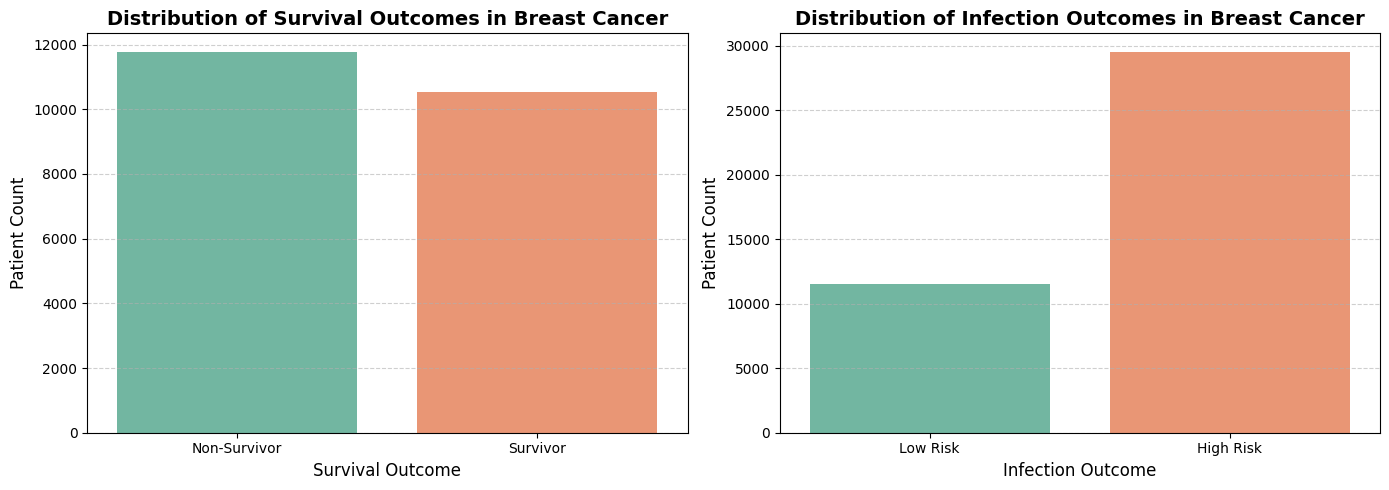

In [16]:
# Plot the distribution of derived survival outcomes and infection risk outcomes side by side with gridlines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for Survival Outcome
sns.countplot(ax=axes[0], x='Survival_Outcome', data=survival_df, palette='Set2')
axes[0].set_title("Distribution of Survival Outcomes in Breast Cancer", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Survival Outcome", fontsize=12)
axes[0].set_ylabel("Patient Count", fontsize=12)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Survivor', 'Survivor'])
axes[0].grid(True, linestyle='--', alpha=0.6, axis='y')  # Add horizontal gridlines

# Bar plot for Infection Outcome
sns.countplot(ax=axes[1], x='Infection_Outcome', data=infection_df, palette='Set2')
axes[1].set_title("Distribution of Infection Outcomes in Breast Cancer", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Infection Outcome", fontsize=12)
axes[1].set_ylabel("Patient Count", fontsize=12)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Low Risk', 'High Risk'])
axes[1].grid(True, linestyle='--', alpha=0.6, axis='y')  # Add horizontal gridlines

plt.tight_layout()
plt.show()


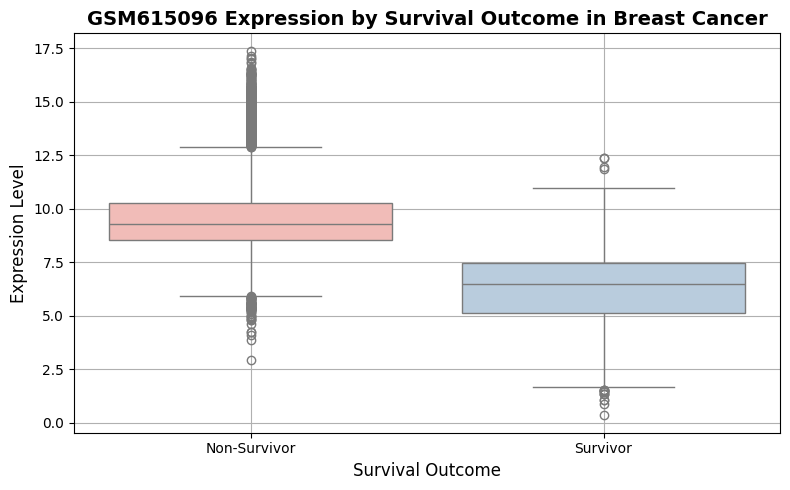

In [17]:
# Compare expression levels of the first gene (GSM column) across survival groups
plt.figure(figsize=(8, 5))
sns.boxplot(x='Survival_Outcome', y=survival_gsm_cols[0], data=survival_df, palette='Pastel1')
plt.title(f"{survival_gsm_cols[0]} Expression by Survival Outcome in Breast Cancer", fontsize=14, fontweight='bold')
plt.xlabel("Survival Outcome", fontsize=12)
plt.ylabel("Expression Level", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Survivor', 'Survivor'])
plt.grid(True)  # Adding gridlines
plt.tight_layout()
plt.show()


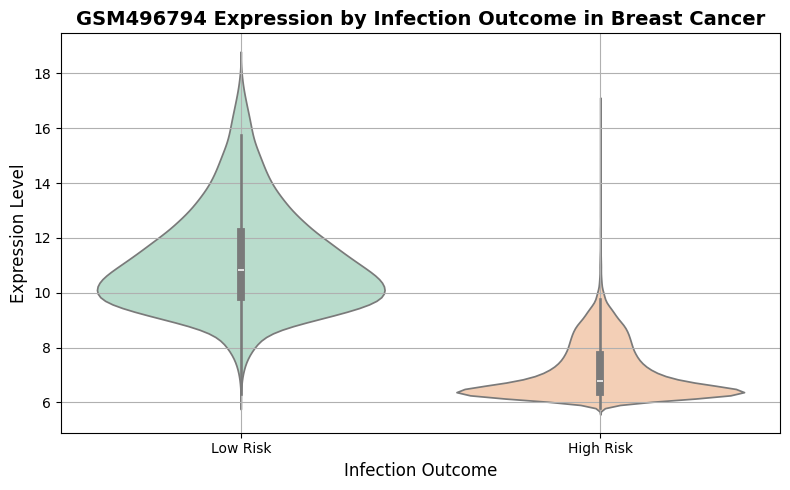

In [18]:
# Show expression distribution with density shape for infection risk outcome
plt.figure(figsize=(8, 5))
sns.violinplot(x='Infection_Outcome', y=infection_gsm_cols[0], data=infection_df, palette='Pastel2')
plt.title(f"{infection_gsm_cols[0]} Expression by Infection Outcome in Breast Cancer", fontsize=14, fontweight='bold')
plt.xlabel("Infection Outcome", fontsize=12)
plt.ylabel("Expression Level", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Low Risk', 'High Risk'])
plt.grid(True)  # Adding gridlines
plt.tight_layout()
plt.show()


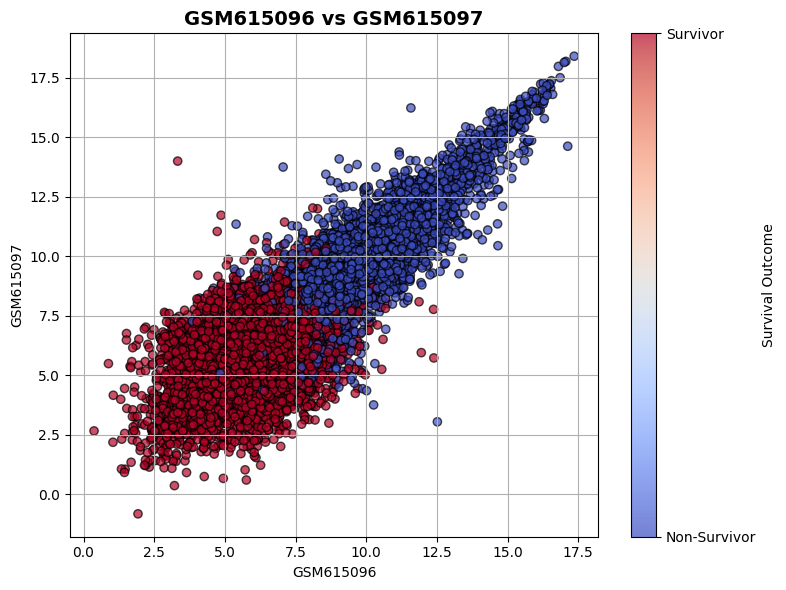

In [19]:
# Scatter plot comparing two gene expressions, color-coded by survival outcome
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    survival_df[survival_gsm_cols[0]],
    survival_df[survival_gsm_cols[1]],
    c=survival_df['Survival_Outcome'],
    cmap='coolwarm', edgecolor='k', alpha=0.7
)
cbar = plt.colorbar(scatter)
cbar.set_label('Survival Outcome')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Non-Survivor', 'Survivor'])
plt.title(f"{survival_gsm_cols[0]} vs {survival_gsm_cols[1]}", fontsize=14, fontweight='bold')
plt.xlabel(survival_gsm_cols[0])
plt.ylabel(survival_gsm_cols[1])
plt.grid(True)  # Adding gridlines
plt.tight_layout()
plt.show()


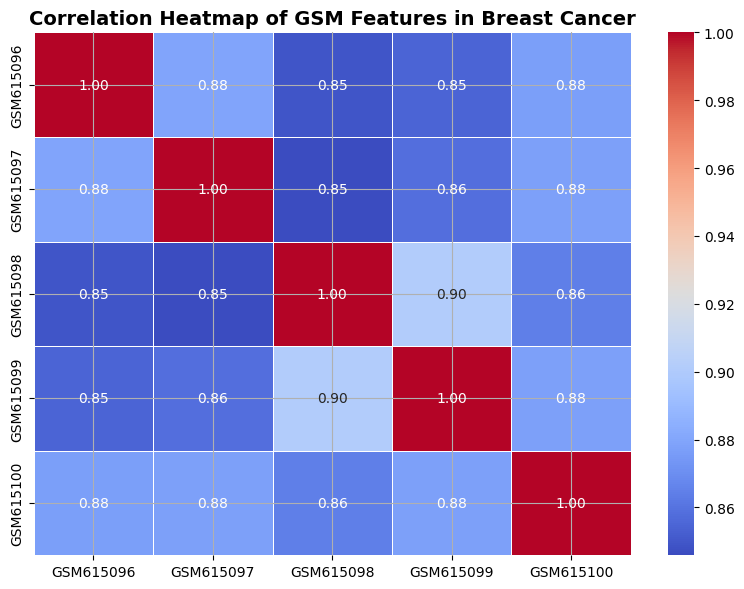

In [20]:
# Visualize correlations between the first five gene expression features
plt.figure(figsize=(8, 6))
corr = survival_df[survival_gsm_cols[:5]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of GSM Features in Breast Cancer", fontsize=14, fontweight='bold')
plt.grid(True)  # Adding gridlines
plt.tight_layout()
plt.show()


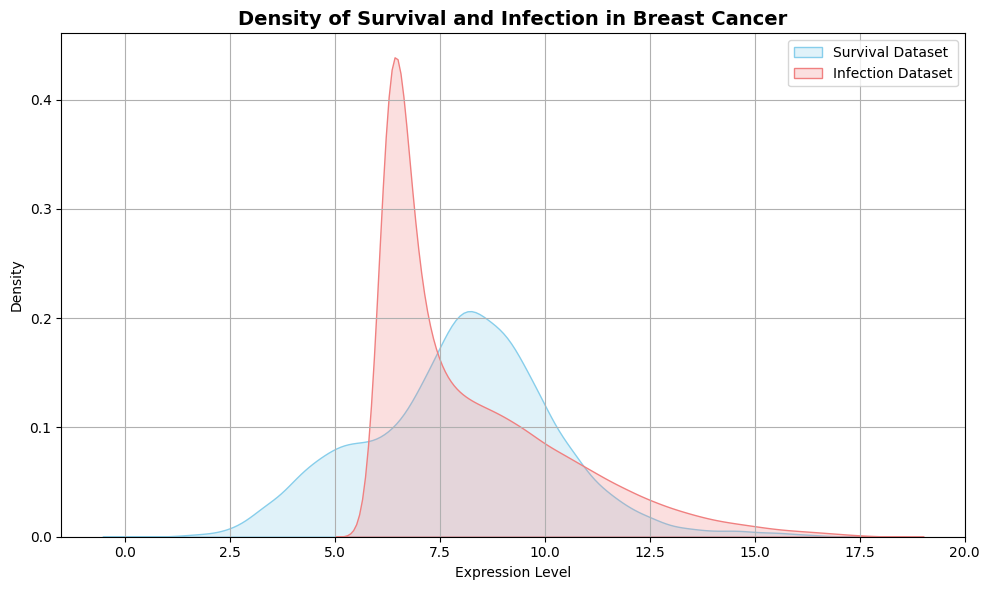

In [21]:
# Compare the distribution of expression for a selected gene across both datasets
plt.figure(figsize=(10, 6))
sns.kdeplot(survival_df[survival_gsm_cols[0]], label='Survival Dataset', fill=True, color='skyblue')
sns.kdeplot(infection_df[infection_gsm_cols[0]], label='Infection Dataset', fill=True, color='lightcoral')
plt.title(f"Density of Survival and Infection in Breast Cancer", fontsize=14, fontweight='bold')
plt.xlabel("Expression Level")
plt.ylabel("Density")
plt.legend()
plt.grid(True)  # Adding gridlines
plt.tight_layout()
plt.show()


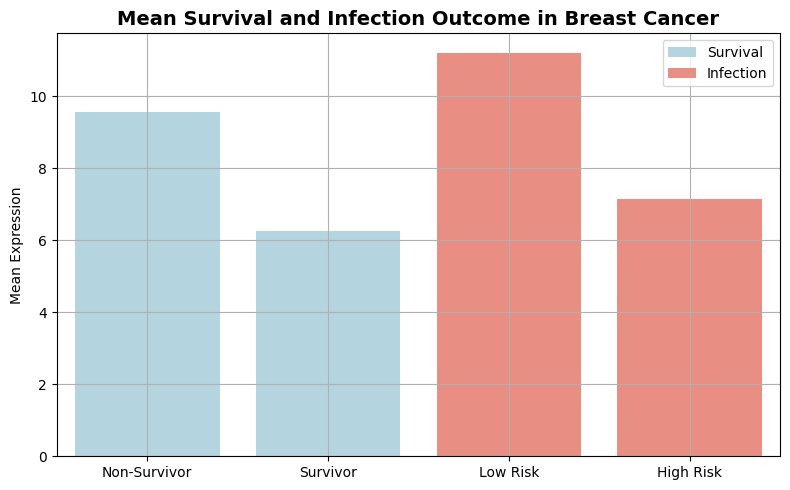

In [22]:
# Compute the mean expression of the first GSM feature for each outcome group
mean_survival = survival_df.groupby('Survival_Outcome')[survival_gsm_cols[0]].mean().reset_index()
mean_infection = infection_df.groupby('Infection_Outcome')[infection_gsm_cols[0]].mean().reset_index()

# Mean expression of the first GSM feature in each outcome group for both datasets
fig, ax = plt.subplots(figsize=(8, 5))

# Plot survival data
sns.barplot(x=['Non-Survivor', 'Survivor'], y=mean_survival[survival_gsm_cols[0]], color='lightblue', label='Survival')

# Plot infection data
sns.barplot(x=['Low Risk', 'High Risk'], y=mean_infection[infection_gsm_cols[0]], color='salmon', label='Infection')

# Title and labels
plt.title(f"Mean Survival and Infection Outcome in Breast Cancer", fontsize=14, fontweight='bold')
plt.ylabel("Mean Expression")
plt.legend()
plt.grid(True)  # Adding gridlines
plt.tight_layout()
plt.show()


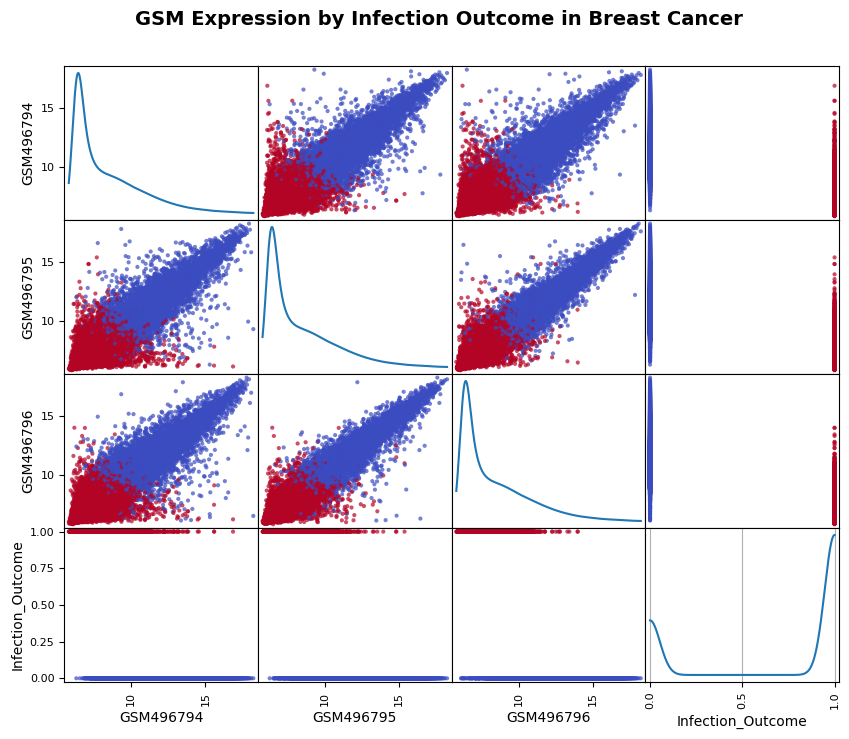

In [23]:
# Visualize relationships between first 3 genes in infection dataset, colored by infection risk
pd.plotting.scatter_matrix(
    infection_df[list(infection_gsm_cols[:3]) + ['Infection_Outcome']],
    figsize=(10, 8),
    alpha=0.7,
    diagonal='kde',
    c=infection_df['Infection_Outcome'],
    cmap='coolwarm'
)
plt.suptitle("GSM Expression by Infection Outcome in Breast Cancer", y=0.95, fontsize=14, fontweight='bold')
plt.grid(True)  # Adding gridlines
plt.show()


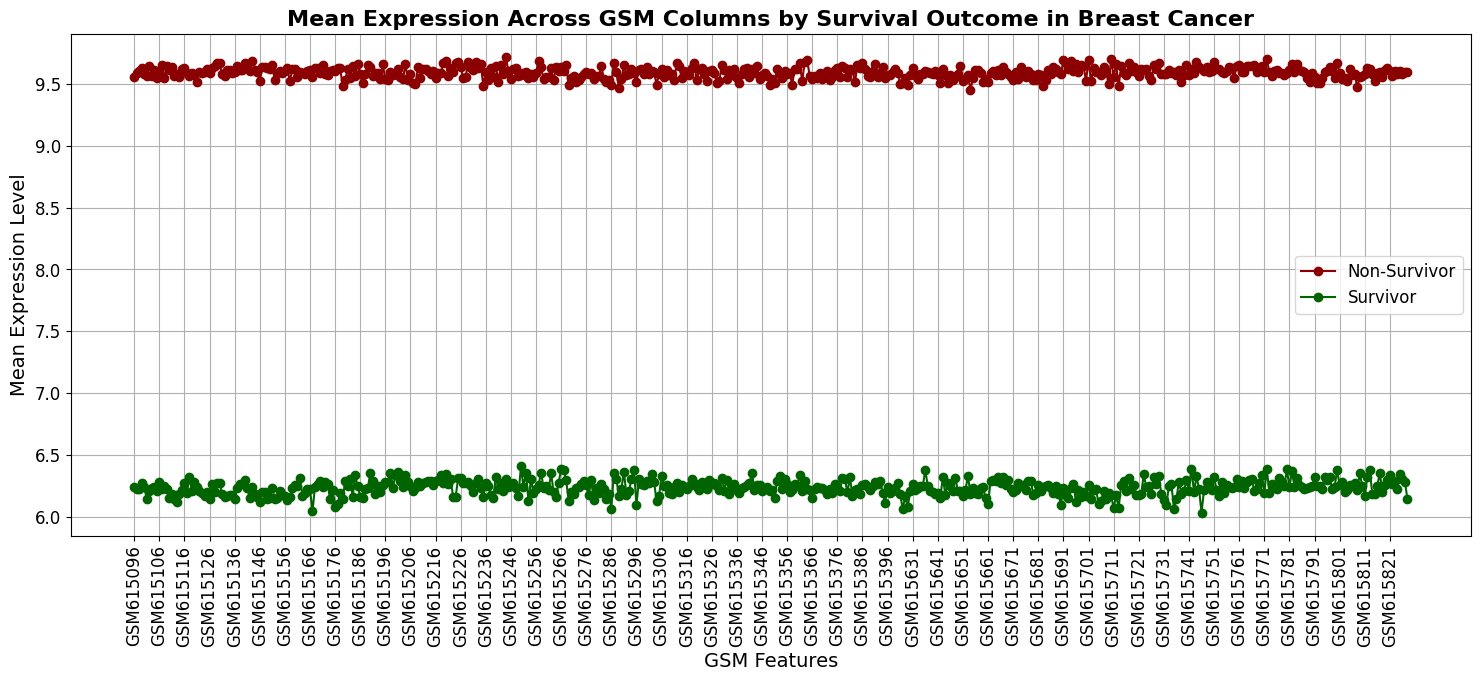

In [24]:
# Compute the mean expression for each survival outcome group (0 = Non-Survivor, 1 = Survivor)
mean_expression = survival_df.groupby('Survival_Outcome')[survival_gsm_cols].mean().T

# Line plot showing average gene expression across all GSMs for each survival group
plt.figure(figsize=(16, 8))  # Increased figure size for better clarity
plt.plot(mean_expression.index, mean_expression[0], label='Non-Survivor', marker='o', color='darkred', markersize=6)
plt.plot(mean_expression.index, mean_expression[1], label='Survivor', marker='o', color='darkgreen', markersize=6)
plt.title("Mean Expression Across GSM Columns by Survival Outcome in Breast Cancer", fontsize=16, fontweight='bold')  # Increased title font size
plt.xlabel("GSM Features", fontsize=14)
plt.ylabel("Mean Expression Level", fontsize=14)

# Reduce the number of x-axis labels by showing every 10th index
plt.xticks(mean_expression.index[::10], rotation=90, fontsize=12)  # Show every 10th label
plt.yticks(fontsize=12)  # Adjusted font size for y-axis ticks
plt.legend(fontsize=12)
plt.grid(True)  # Adding gridlines for better clarity
plt.tight_layout(pad=5.0)  # Increased padding to avoid overlap
plt.show()


**Random Forest for Breast Cancer Prediction**

In [25]:
# Simplified grid search and parallel processing
rf_params = {'n_estimators': [50], 'max_depth': [10]}  # Reduced options
rf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores

# Store results
rf_results = {}

# Survival Rate
rf_sur = rf.fit(X_sur_train, y_sur_train)
rf_sur_pred = rf_sur.predict(X_sur_test)
rf_sur_prob = rf_sur.predict_proba(X_sur_test)[:, 1]
rf_results['Survival'] = {
    'Accuracy': accuracy_score(y_sur_test, rf_sur_pred),
    'RMSE': np.sqrt(mean_squared_error(y_sur_test, rf_sur_pred)),
    'R2': r2_score(y_sur_test, rf_sur_pred),
    'AUC': roc_auc_score(y_sur_test, rf_sur_prob) if len(np.unique(y_sur_test)) > 1 else 0
}
print("\nRF Survival Accuracy:", rf_results['Survival']['Accuracy'])
print("RF Survival RMSE:", rf_results['Survival']['RMSE'])
print("RF Survival R²:", rf_results['Survival']['R2'])
if len(np.unique(y_sur_test)) > 1:
    print("RF Survival AUC:", rf_results['Survival']['AUC'])

# Save Random Forest model for Survival
joblib.dump(rf_sur, 'rf_survival_model.joblib')


RF Survival Accuracy: 0.9840700022436617
RF Survival RMSE: 0.12621409491945954
RF Survival R²: 0.9360772792519163
RF Survival AUC: 0.9991082650467775


['rf_survival_model.joblib']

In [26]:
# Treatment Analysis
rf_trt = GridSearchCV(rf, rf_params, cv=5).fit(X_trt_train, y_trt_train)
print("Best RF Treatment Params:", rf_trt.best_params_)
rf_trt_pred = rf_trt.predict(X_trt_test)
rf_trt_prob = rf_trt.predict_proba(X_trt_test)[:, 1]
rf_results['Treatment'] = {
    'Accuracy': accuracy_score(y_trt_test, rf_trt_pred),
    'RMSE': np.sqrt(mean_squared_error(y_trt_test, rf_trt_pred)),
    'R2': r2_score(y_trt_test, rf_trt_pred),
    'AUC': roc_auc_score(y_trt_test, rf_trt_prob) if len(np.unique(y_trt_test)) > 1 else 0
}
print("RF Treatment Accuracy:", rf_results['Treatment']['Accuracy'])
print("RF Treatment RMSE:", rf_results['Treatment']['RMSE'])
print("RF Treatment R²:", rf_results['Treatment']['R2'])
if len(np.unique(y_trt_test)) > 1:
    print("RF Treatment AUC:", rf_results['Treatment']['AUC'])

# Save Random Forest model for Treatment
joblib.dump(rf_trt.best_estimator_, 'rf_treatment_model.joblib')

Best RF Treatment Params: {'max_depth': 10, 'n_estimators': 50}
RF Treatment Accuracy: 0.9807045097599282
RF Treatment RMSE: 0.13890820796508677
RF Treatment R²: 0.922576389012328
RF Treatment AUC: 0.9988288553242444


['rf_treatment_model.joblib']

In [27]:
# Infection Risk
rf_inf = rf.fit(X_inf_train, y_inf_train)
rf_inf_pred = rf_inf.predict(X_inf_test)
rf_inf_prob = rf_inf.predict_proba(X_inf_test)[:, 1]
rf_results['Infection'] = {
    'Accuracy': accuracy_score(y_inf_test, rf_inf_pred),
    'RMSE': np.sqrt(mean_squared_error(y_inf_test, rf_inf_pred)),
    'R2': r2_score(y_inf_test, rf_inf_pred),
    'AUC': roc_auc_score(y_inf_test, rf_inf_prob) if len(np.unique(y_inf_test)) > 1 else 0
}
print("RF Infection Accuracy:", rf_results['Infection']['Accuracy'])
print("RF Infection RMSE:", rf_results['Infection']['RMSE'])
print("RF Infection R²:", rf_results['Infection']['R2'])
if len(np.unique(y_inf_test)) > 1:
    print("RF Infection AUC:", rf_results['Infection']['AUC'])


# Save Random Forest model for Infection
joblib.dump(rf_inf, 'rf_infection_model.joblib')

RF Infection Accuracy: 0.9939024390243902
RF Infection RMSE: 0.07808688094430304
RF Infection R²: 0.9696324166989415
RF Infection AUC: 0.9998323116863571


['rf_infection_model.joblib']

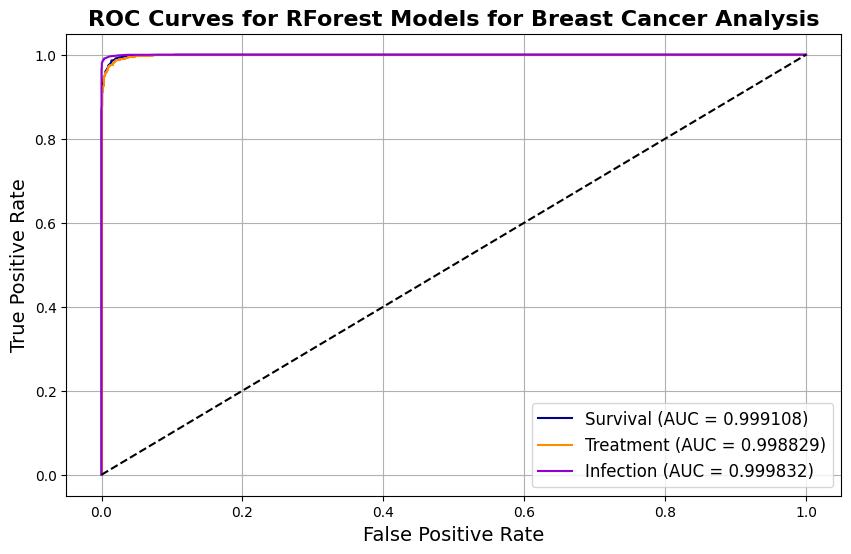

In [28]:
# ROC Curves for Random Forest Models
plt.figure(figsize=(10, 6))
colors = ['darkblue', 'darkorange', 'darkviolet']  # Define colors for each curve
for i, (name, y_test, prob) in enumerate([('Survival', y_sur_test, rf_sur_prob),
                                           ('Treatment', y_trt_test, rf_trt_prob),
                                           ('Infection', y_inf_test, rf_inf_prob)]):
    if len(np.unique(y_test)) > 1:
        fpr, tpr, _ = roc_curve(y_test, prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.6f})', color=colors[i])  # Assign color to each curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curves for RForest Models for Breast Cancer Analysis", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)  # Add gridlines for better clarity
plt.show()


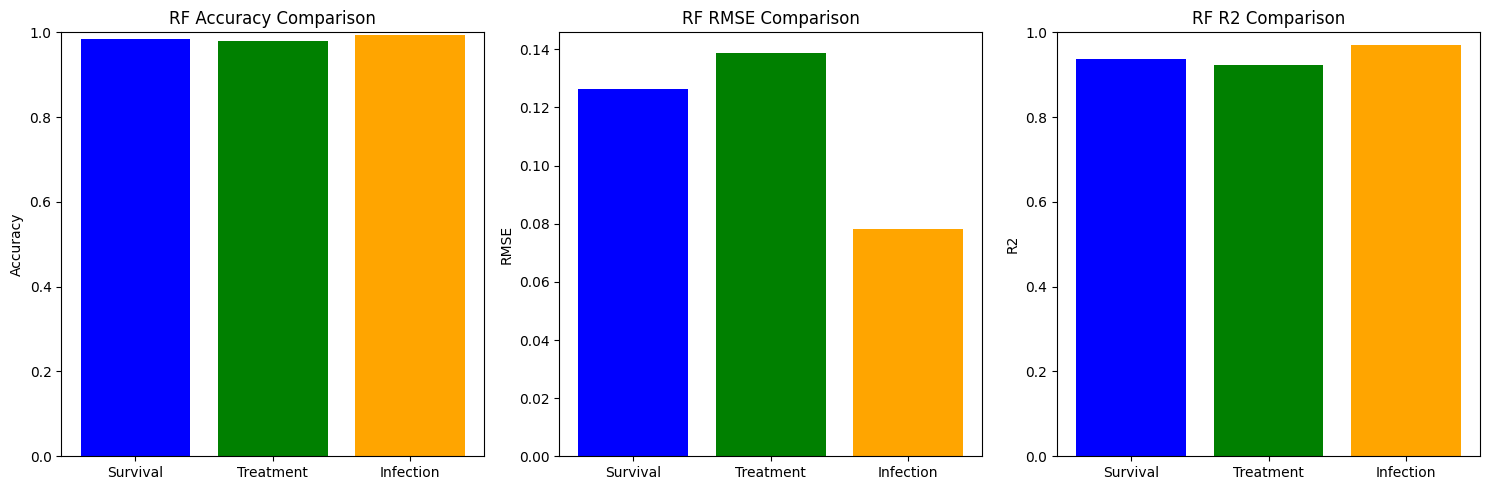

In [29]:
# Comparison Bar Plot
metrics = ['Accuracy', 'RMSE', 'R2']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    axes[i].bar(rf_results.keys(), [rf_results[k][metric] for k in rf_results], color=['blue', 'green', 'orange'])
    axes[i].set_title(f'RF {metric} Comparison')
    axes[i].set_ylim(0, 1 if metric != 'RMSE' else None)
    axes[i].set_ylabel(metric)
plt.tight_layout()
plt.show()

**Neural Network models for breast cancer outcomes**

In [30]:
def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Survival
nn_sur = build_nn(X_sur_train.shape[1])
history_sur = nn_sur.fit(X_sur_train, y_sur_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)
nn_sur_prob = nn_sur.predict(X_sur_test)
nn_sur_pred = (nn_sur_prob > 0.5).astype(int).flatten()
nn_sur_results = {
    'Accuracy': accuracy_score(y_sur_test, nn_sur_pred),
    'RMSE': np.sqrt(mean_squared_error(y_sur_test, nn_sur_pred)),
    'R2': r2_score(y_sur_test, nn_sur_pred),
    'AUC': roc_auc_score(y_sur_test, nn_sur_prob) if len(np.unique(y_sur_test)) > 1 else 0
}
print("NN Survival Results:", nn_sur_results)

# Save Neural Network model for Survival
nn_sur.save('nn_survival_model.h5')

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9666 - loss: 0.0753 - val_accuracy: 0.9933 - val_loss: 0.0160
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9963 - loss: 0.0117 - val_accuracy: 0.9947 - val_loss: 0.0136
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9952 - val_loss: 0.0118
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9961 - val_loss: 0.0117
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 0.9958 - val_loss: 0.0136
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9961 - val_loss: 0.0139
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.9958 - val_loss: 0.0164
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.4509e-04 - val_accurac

NN Survival Results: {'Accuracy': 0.9955126766883554, 'RMSE': np.float64(0.06698748623171796), 'R2': 0.9819935997892721, 'AUC': np.float64(0.9999359655725061)}


In [31]:
# Treatment
nn_trt = build_nn(X_trt_train.shape[1])
history_trt = nn_trt.fit(X_trt_train, y_trt_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
nn_trt_prob = nn_trt.predict(X_trt_test)
nn_trt_pred = (nn_trt_prob > 0.5).astype(int).flatten()
nn_trt_results = {
    'Accuracy': accuracy_score(y_trt_test, nn_trt_pred),
    'RMSE': np.sqrt(mean_squared_error(y_trt_test, nn_trt_pred)),
    'R2': r2_score(y_trt_test, nn_trt_pred),
    'AUC': roc_auc_score(y_trt_test, nn_trt_prob) if len(np.unique(y_trt_test)) > 1 else 0
}
print("NN Treatment Results:", nn_trt_results)

# Save Neural Network model for Treatment
nn_trt.save('nn_treatment_model.h5')

Epoch 1/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9812 - loss: 0.0557 - val_accuracy: 0.9936 - val_loss: 0.0136
Epoch 2/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9955 - val_loss: 0.0122
Epoch 3/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0043 - val_accuracy: 0.9944 - val_loss: 0.0129
Epoch 4/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9961 - val_loss: 0.0138
Epoch 5/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9941 - val_loss: 0.0126
Epoch 6/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0021 - val_accuracy: 0.9907 - val_loss: 0.0342
Epoch 7/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9938 - val_loss: 0.0192
Epoch 8/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.

NN Treatment Results: {'Accuracy': 0.9961857751851021, 'RMSE': np.float64(0.0617594107395619), 'R2': 0.9846953327117393, 'AUC': np.float64(0.9999608137172997)}


In [32]:
# Infection
nn_inf = build_nn(X_inf_train.shape[1])
history_inf = nn_inf.fit(X_inf_train, y_inf_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
nn_inf_prob = nn_inf.predict(X_inf_test)
nn_inf_pred = (nn_inf_prob > 0.5).astype(int).flatten()
nn_inf_results = {
    'Accuracy': accuracy_score(y_inf_test, nn_inf_pred),
    'RMSE': np.sqrt(mean_squared_error(y_inf_test, nn_inf_pred)),
    'R2': r2_score(y_inf_test, nn_inf_pred),
    'AUC': roc_auc_score(y_inf_test, nn_inf_prob) if len(np.unique(y_inf_test)) > 1 else 0
}
print("NN Infection Results:", nn_inf_results)

# Save Neural Network model for Infection
nn_inf.save('nn_infection_model.h5')

Epoch 1/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9408 - loss: 0.1400 - val_accuracy: 0.9887 - val_loss: 0.0296
Epoch 2/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9882 - loss: 0.0285 - val_accuracy: 0.9921 - val_loss: 0.0246
Epoch 3/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9918 - loss: 0.0200 - val_accuracy: 0.9924 - val_loss: 0.0208
Epoch 4/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9932 - loss: 0.0174 - val_accuracy: 0.9944 - val_loss: 0.0167
Epoch 5/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9937 - loss: 0.0155 - val_accuracy: 0.9928 - val_loss: 0.0157
Epoch 6/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9935 - loss: 0.0144 - val_accuracy: 0.9928 - val_loss: 0.0151
Epoch 7/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9949 - loss: 0.0113 - val_accuracy: 0.9895 - val_loss: 0.0259
Epoch 8/20
820/820 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9960 - loss: 0.0106 - val_accuracy: 0.

NN Infection Results: {'Accuracy': 0.9930487804878049, 'RMSE': np.float64(0.08337397382993761), 'R2': 0.9653809550367933, 'AUC': np.float64(0.9998575686275905)}


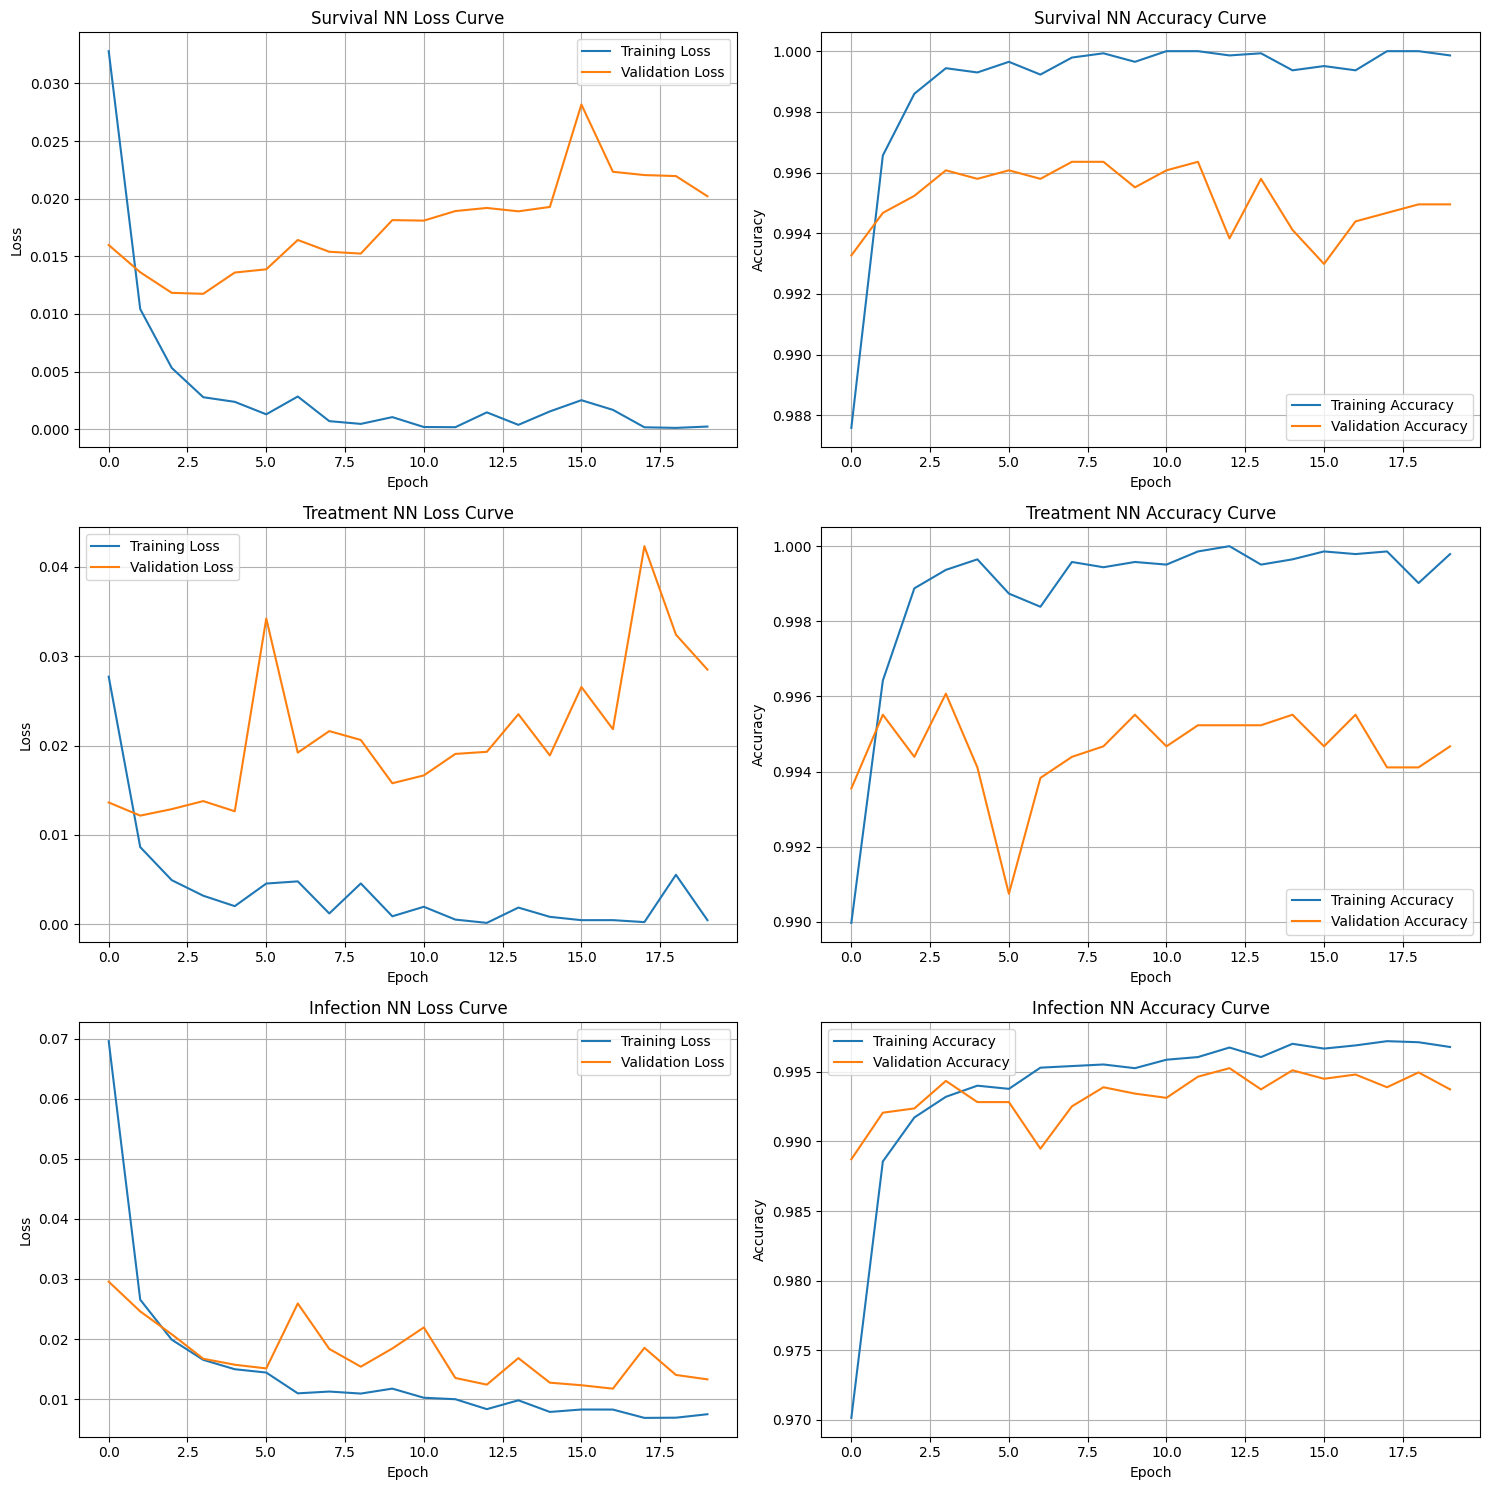

In [33]:
# Loss and Accuracy Plots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, (history, title) in enumerate([(history_sur, 'Survival'), (history_trt, 'Treatment'), (history_inf, 'Infection')]):
    # Loss
    axes[i, 0].plot(history.history['loss'], label='Training Loss')
    axes[i, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[i, 0].set_title(f'{title} NN Loss Curve')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()
    axes[i, 0].grid(True)  # Add gridlines for Loss plot

    # Accuracy
    axes[i, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[i, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[i, 1].set_title(f'{title} NN Accuracy Curve')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()
    axes[i, 1].grid(True)  # Add gridlines for Accuracy plot

plt.tight_layout()
plt.show()


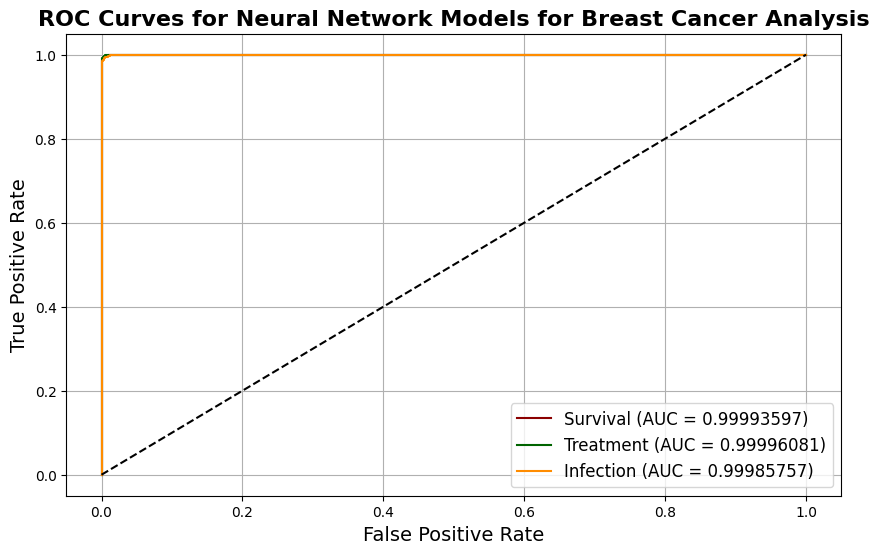

In [34]:
# ROC Curves
plt.figure(figsize=(10, 6))
colors = ['darkred', 'darkgreen', 'darkorange']  # Define colors for each curve
for i, (name, y_test, prob) in enumerate([('Survival', y_sur_test, nn_sur_prob),
                                           ('Treatment', y_trt_test, nn_trt_prob),
                                           ('Infection', y_inf_test, nn_inf_prob)]):
    if len(np.unique(y_test)) > 1:
        fpr, tpr, _ = roc_curve(y_test, prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.8f})', color=colors[i])  # Assign color to each curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curves for Neural Network Models for Breast Cancer Analysis", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)  # Add gridlines
plt.show()


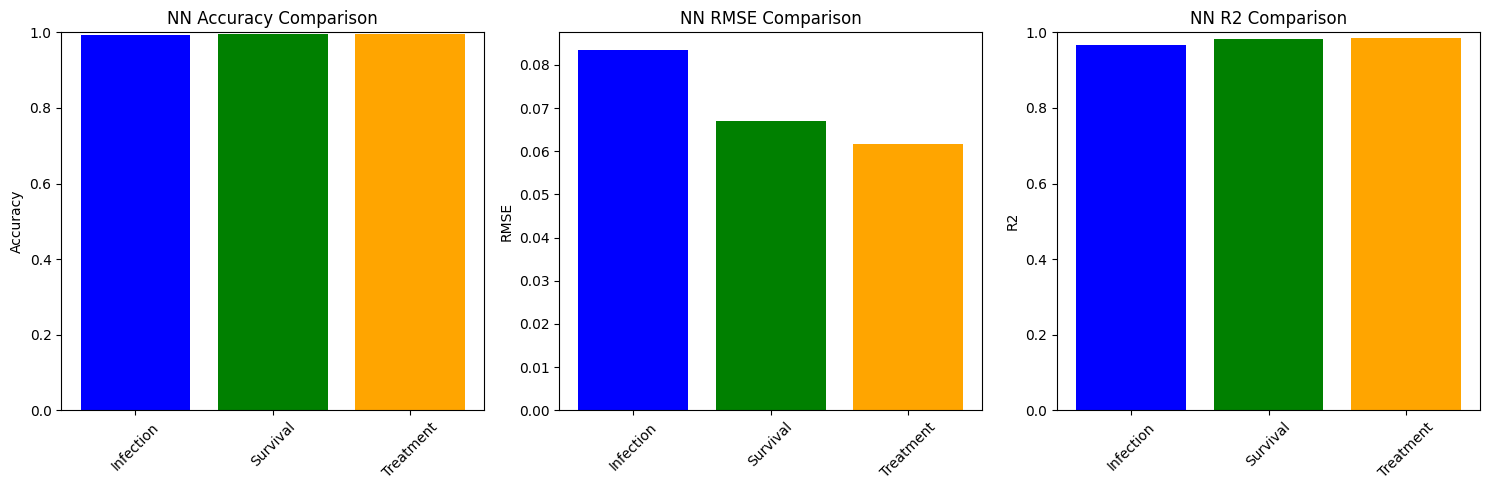

In [35]:
# Combine results into a single dictionary for plotting
nn_results = {
    'Infection': nn_inf_results,
    'Survival': nn_sur_results,
    'Treatment': nn_trt_results
}



metrics = ['Accuracy', 'RMSE', 'R2']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    values = [nn_results[k][metric] for k in nn_results]
    axes[i].bar(nn_results.keys(), values, color=['blue', 'green', 'orange'])
    axes[i].set_title(f'NN {metric} Comparison')
    if metric != 'RMSE':
        axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(metric)
    axes[i].set_xticklabels(nn_results.keys(), rotation=45)

plt.tight_layout()
plt.show()


**SHAP Analysis and Model Comparison**

<Figure size 1200x800 with 0 Axes>

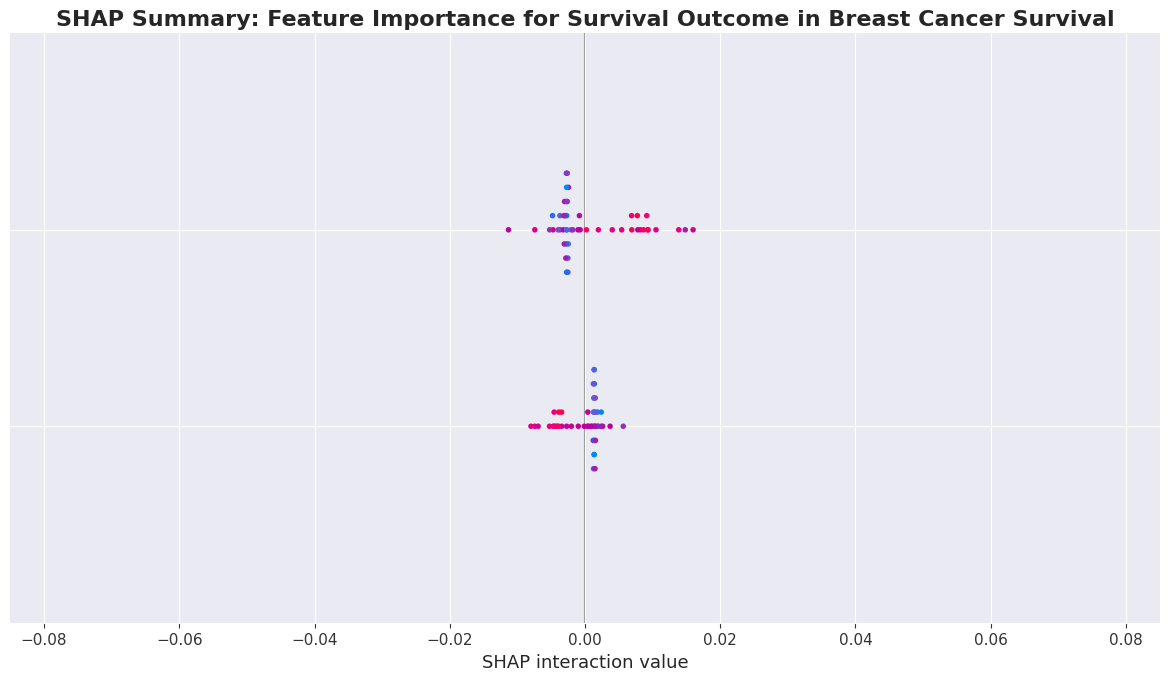

In [36]:
# SHAP Analysis and Model Comparison

sns.set_style("darkgrid")

explainer = shap.TreeExplainer(rf_sur)
shap_values = explainer.shap_values(X_sur_test[:50])

# Set the figure size
plt.figure(figsize=(12, 8))

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_sur_test[:50], feature_names=X_survival.columns,
                  plot_type="dot", color="coolwarm", show=False)

# Set the title and display the plot
plt.title("SHAP Summary: Feature Importance for Survival Outcome in Breast Cancer Survival", fontsize=16, fontweight='bold')
plt.show()


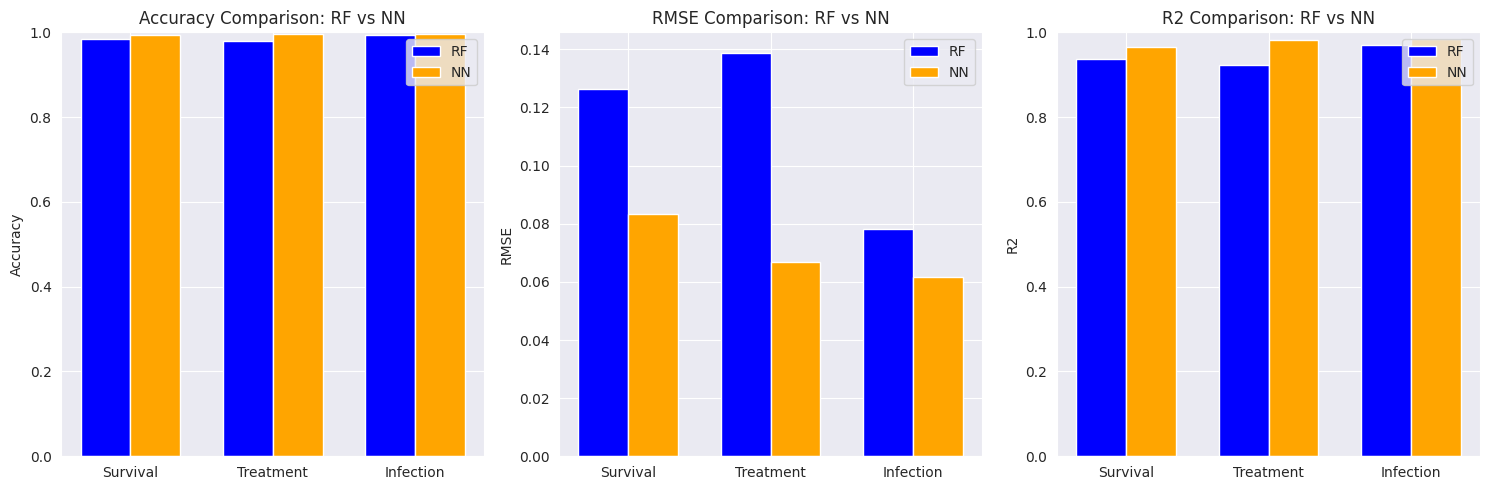

In [37]:
# Model Comparison
metrics = ['Accuracy', 'RMSE', 'R2']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    rf_vals = [rf_results[k][metric] for k in rf_results]
    nn_vals = [nn_results[k][metric] for k in nn_results]
    x = np.arange(len(rf_results))
    width = 0.35
    axes[i].bar(x - width/2, rf_vals, width, label='RF', color='blue')
    axes[i].bar(x + width/2, nn_vals, width, label='NN', color='orange')
    axes[i].set_title(f'{metric} Comparison: RF vs NN')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(rf_results.keys())
    axes[i].set_ylim(0, 1 if metric != 'RMSE' else None)
    axes[i].set_ylabel(metric)
    axes[i].legend()
plt.tight_layout()
plt.show()



# **Gradio Deployment**

In [38]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 134.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [40]:
import gradio as gr
import numpy as np
import joblib
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from sklearn.preprocessing import StandardScaler

# --- Load models & scaler ---
rf_survival_model  = joblib.load('rf_survival_model.joblib')
rf_treatment_model = joblib.load('rf_treatment_model.joblib')
rf_infection_model = joblib.load('rf_infection_model.joblib')
infection_scaler   = joblib.load('scaler.joblib')

# --- Constants & autofill ---
FEATURES_SURVIVAL, FEATURES_INFECTION = 508, 115
AUTOFILL_VALUES = {
    "g1": 12.359267,
    "g2": 12.613243,
    "g3": 11.551397,
    "g4": 11.828700,
    "g5": 11.983987
}
autofill_mean = np.mean(list(AUTOFILL_VALUES.values()))
autofill_std  = np.std(list(AUTOFILL_VALUES.values()))

def custom_scale_508(X):
    return (X - autofill_mean) / autofill_std

# --- Donut chart helper ---
def donut_chart(prob, label, color):
    fig, ax = plt.subplots(figsize=(5,5))
    wedges, _ = ax.pie(
        [prob, 1-prob],
        startangle=90,
        colors=[color, "#e0e0e0"],
        wedgeprops=dict(width=0.4, edgecolor='white')
    )
    ax.text(0, 0, f"{prob*100:.1f}%", ha='center', va='center', fontsize=28, color=color)
    ax.set_title(label, fontsize=20)
    ax.axis('equal')
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    data = base64.b64encode(buf.getvalue()).decode('utf-8')
    return f"<img src='data:image/png;base64,{data}' width='250' height='250'/>"

# --- Prediction function ---
def predict_breast_cancer_outcomes(g1, g2, g3, g4, g5):
    vals = [g1, g2, g3, g4, g5]
    if any(v is None for v in vals):
        return "<div style='color:red;font-size:18px;'>Error: Please provide all 5 values.</div>"

    # Build feature vectors
    surv = np.repeat(vals, FEATURES_SURVIVAL//5 + 1)[:FEATURES_SURVIVAL].reshape(1,-1)
    inf  = np.repeat(vals, FEATURES_INFECTION//5 + 1)[:FEATURES_INFECTION].reshape(1,-1)

    # Scale & predict
    surv_s = custom_scale_508(surv)
    inf_s  = infection_scaler.transform(inf)
    p_surv = rf_survival_model.predict_proba(surv_s)[0,1]
    p_trt  = rf_treatment_model.predict_proba(surv_s)[0,1]
    p_inf  = rf_infection_model.predict_proba(inf_s)[0,1]

    # Generate charts
    surv_img = donut_chart(p_surv,  "Survival",  "#4CAF50" if p_surv>0.5 else "#F44336")
    trt_img  = donut_chart(p_trt,   "Treatment", "#2196F3" if p_trt>0.5 else "#FFC107")
    inf_img  = donut_chart(p_inf,   "Infection", "#9C27B0" if p_inf>0.5 else "#03A9F4")

    # Return side-by-side
    return f"""
    <div style='display:flex; justify-content:space-around; padding:20px;'>
      <div>{surv_img}</div>
      <div>{trt_img}</div>
      <div>{inf_img}</div>
    </div>
    """

# --- Clear & Reset ---
def initial_output():
    return "<div style='text-align:center; font-size:18px; color:#666;'>Donut charts will appear here</div>"

def clear_inputs():
    return [None]*5 + [initial_output()]

def reset_inputs():
    return list(AUTOFILL_VALUES.values()) + [initial_output()]

# --- Build Gradio UI ---
css = '''
body { background: linear-gradient(120deg, #ece9e6, #ffffff); }
.gr-button { font-size:16px !important; }
'''

with gr.Blocks(css=css, theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Breast Cancer Outcome Predictor")
    gr.Markdown("Enter five gene expression values to Predit outcome.")

    with gr.Row():
        g1 = gr.Number(label="REF_ID 1", value=AUTOFILL_VALUES["g1"])
        g2 = gr.Number(label="REF_ID 2", value=AUTOFILL_VALUES["g2"])
        g3 = gr.Number(label="REF_ID 3", value=AUTOFILL_VALUES["g3"])
        g4 = gr.Number(label="REF_ID 4", value=AUTOFILL_VALUES["g4"])
        g5 = gr.Number(label="REF_ID 5", value=AUTOFILL_VALUES["g5"])

    with gr.Row():
        predict_btn = gr.Button("Predict Outcomes", variant="primary")
        clear_btn   = gr.Button("Clear", variant="secondary")
        reset_btn   = gr.Button("Reset to Default", variant="secondary")

    output = gr.HTML(initial_output(), label="Prediction Charts")

    predict_btn.click(predict_breast_cancer_outcomes, [g1,g2,g3,g4,g5], output)
    clear_btn.click(clear_inputs, [], [g1,g2,g3,g4,g5,output])
    reset_btn.click(reset_inputs,  [], [g1,g2,g3,g4,g5,output])

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e0ead43b5f8c5b6309.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
